In [2]:
import numpy as np
import pandas as pd
import pyBigWig
import matplotlib.pyplot as plt
import time
window_kb = 5
bin_size = 10
version = ['v2','v3']
Genome = ['mm10','hg38']

# QC filtering

Nr. of TF experiments for mm10 = 18926
27 TF with > 128 experiments
Nr. of TF experiments for mm10 = 14057
Nr. of TF experiments for hg38 = 27430
25 TF with > 128 experiments
Nr. of TF experiments for hg38 = 19507
Nr. of TF experiments for mm10 = 23006
33 TF with > 128 experiments
Nr. of TF experiments for mm10 = 16082
Nr. of TF experiments for hg38 = 32447
32 TF with > 128 experiments
Nr. of TF experiments for hg38 = 22201


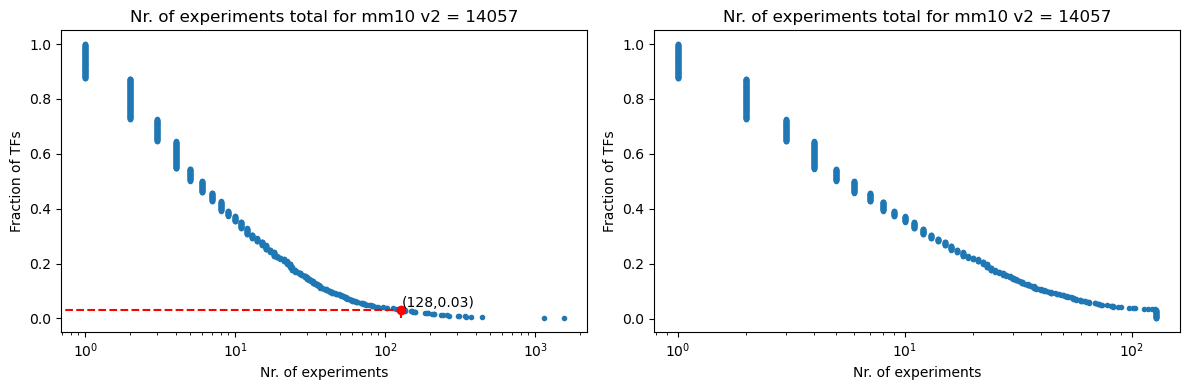

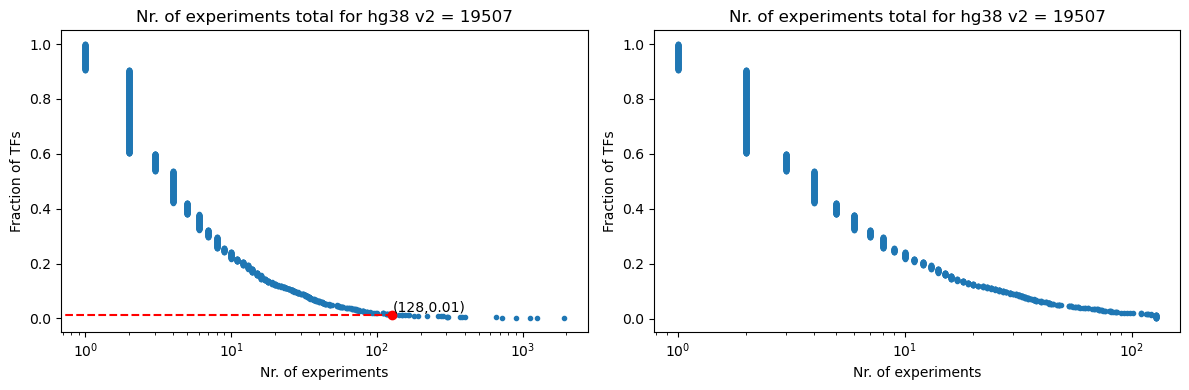

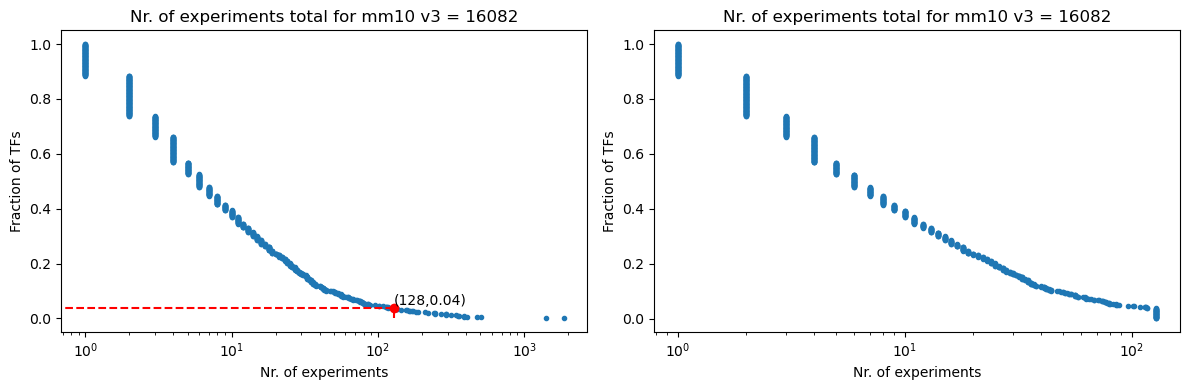

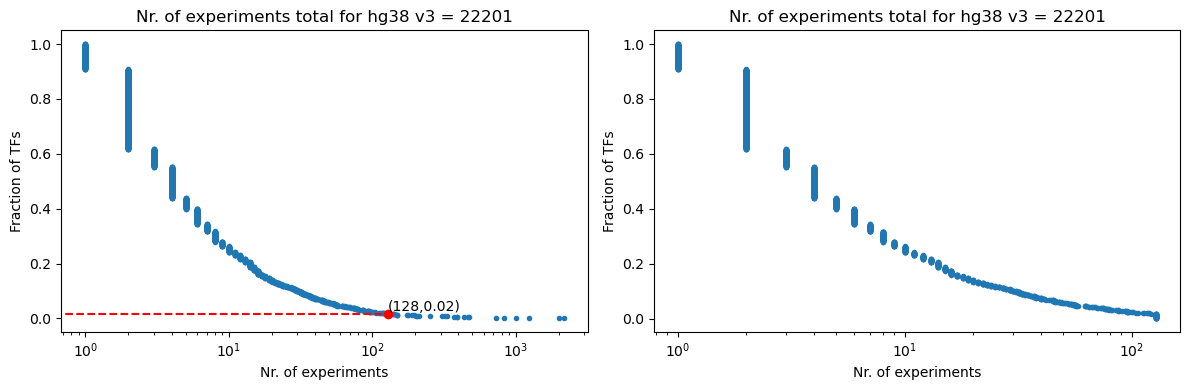

In [3]:
version = ['v2','v3']
Genome = ['mm10','hg38']
for v in version:
    for genome in Genome:

        infile_chip = f'../resources/experimentList_{v}.tab'

        # get experiment table
        chip = pd.read_csv(infile_chip,sep='\t',header=None,usecols=[0,1,2,3,4,5,6,7,8],index_col=0)
        chip.columns = ['genome','antigen_class','antigen','celltype_class','celltype','celltype_description','QC','title']

        # get only TFs and others from genome
        chip = chip[ (chip.genome == genome) & (chip.antigen_class=='TFs and others') ]

        print(f'Nr. of TF experiments for {genome} = {chip.shape[0]}')

        # parse QC column add to chip table
        QC = pd.DataFrame([[float(n) for n in qc.split(',')] for qc in chip.QC],columns=['n_reads','f_mapped','f_duplicates','n_peaks'],index=chip.index)
        QC.iloc[:,1] /= 100
        QC.iloc[:,2] /= 100
        chip = pd.concat([chip,QC],axis=1)

        # get peaks per unique mapped reads
        chip.loc[:,'n_peaks_per_unique_mapped_reads'] = chip.n_peaks/(chip.f_mapped*chip.n_reads*(1-chip.f_duplicates))

        # count nr. of experiments per antigen
        exp_per_tf = chip.groupby('antigen')['antigen'].aggregate('count').sort_values()

        fig, axes = plt.subplots(1,2,figsize=(12,4))

        ax = axes[0]
        ax.plot(exp_per_tf,1-np.arange(len(exp_per_tf))/len(exp_per_tf),'.')
        ax.set_xscale('log')
        th = 128
        f = np.sum(exp_per_tf>th)/len(exp_per_tf)
        ax.plot([th,th],[0,f],'r--')
        ax.plot([0,th],[f,f],'r--')
        ax.plot(th,f,'ro')
        ax.text(th,f,f'({th},{f:.2f})',ha='left',va='bottom')
        ax.set_xlabel('Nr. of experiments')
        ax.set_ylabel('Fraction of TFs')
        ax.set_title(f'Nr. of experiments total for {genome} {v} = {sum( [min(n,th) for n in exp_per_tf] )}')

        print(f'{sum(exp_per_tf>th)} TF with > {th} experiments')

        # For TFs with more than th experiments, keep the th with the highest n_peaks_per_unique_mapped_reads
        idx_out = []
        for tf in exp_per_tf.loc[exp_per_tf > th].index:
            idx_out.extend( list( chip.loc[chip.antigen==tf].sort_values('n_peaks_per_unique_mapped_reads',ascending=False).index[th:] ) )
        chip.drop(idx_out,inplace=True)

        print(f'Nr. of TF experiments for {genome} = {chip.shape[0]}')

        # count nr. of experiments per antigen
        exp_per_tf = chip.groupby('antigen')['antigen'].aggregate('count').sort_values()

        ax = axes[1]
        ax.plot(exp_per_tf,1-np.arange(len(exp_per_tf))/len(exp_per_tf),'.')
        ax.set_xscale('log')
        ax.set_xlabel('Nr. of experiments')
        ax.set_ylabel('Fraction of TFs')
        ax.set_title(f'Nr. of experiments total for {genome} {v} = {sum( [min(n,th) for n in exp_per_tf] )}')

        fig.tight_layout()
        fig.savefig(f'fig/Nr_exp_per_tf_{genome}_{v}.pdf')



# One fig with mm10 and hg38 v3 

Nr. of TF experiments for mm10 = 23006
Nr. of TF experiments for hg38 = 32447


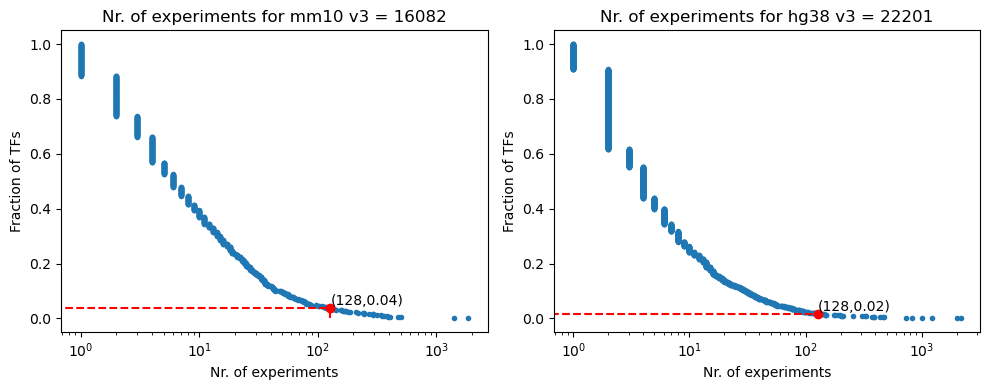

In [5]:

Genome = ['mm10','hg38']
v = 'v3'

fig, axes = plt.subplots(1,2,figsize=(10,4))

for f, genome in enumerate(Genome):


    infile_chip = f'../resources/experimentList_{v}.tab'

    # get experiment table
    chip = pd.read_csv(infile_chip,sep='\t',header=None,usecols=[0,1,2,3,4,5,6,7,8],index_col=0)
    chip.columns = ['genome','antigen_class','antigen','celltype_class','celltype','celltype_description','QC','title']

    # get only TFs and others from genome
    chip = chip[ (chip.genome == genome) & (chip.antigen_class=='TFs and others') ]

    print(f'Nr. of TF experiments for {genome} = {chip.shape[0]}')

    # parse QC column add to chip table
    QC = pd.DataFrame([[float(n) for n in qc.split(',')] for qc in chip.QC],columns=['n_reads','f_mapped','f_duplicates','n_peaks'],index=chip.index)
    QC.iloc[:,1] /= 100
    QC.iloc[:,2] /= 100
    chip = pd.concat([chip,QC],axis=1)

    # get peaks per unique mapped reads
    chip.loc[:,'n_peaks_per_unique_mapped_reads'] = chip.n_peaks/(chip.f_mapped*chip.n_reads*(1-chip.f_duplicates))

    # count nr. of experiments per antigen
    exp_per_tf = chip.groupby('antigen')['antigen'].aggregate('count').sort_values()

    ax = axes[f]
    ax.plot(exp_per_tf,1-np.arange(len(exp_per_tf))/len(exp_per_tf),'.')
    ax.set_xscale('log')
    th = 128
    f = np.sum(exp_per_tf>th)/len(exp_per_tf)
    ax.plot([th,th],[0,f],'r--')
    ax.plot([0,th],[f,f],'r--')
    ax.plot(th,f,'ro')
    ax.text(th,f,f'({th},{f:.2f})',ha='left',va='bottom')
    ax.set_xlabel('Nr. of experiments')
    ax.set_ylabel('Fraction of TFs')
    ax.set_title(f'Nr. of experiments for {genome} {v} = {sum( [min(n,th) for n in exp_per_tf] )}')



fig.tight_layout()
fig.savefig(f'fig/Nr_exp_per_tf_mm10_hg38_{v}.pdf')


# BW binning

1590788746.9357803
1590788746.9441829


/tmp/ipykernel_26841/2281230118.py:55: RuntimeWarning: Mean of empty slice
  X_[:,e] = np.nanmean( Vals.reshape(N_pos,bin_size), axis=1)
/tmp/ipykernel_26841/2281230118.py:55: RuntimeWarning: Mean of empty slice
  X_[:,e] = np.nanmean( Vals.reshape(N_pos,bin_size), axis=1)
/tmp/ipykernel_26841/2281230118.py:55: RuntimeWarning: Mean of empty slice
  X_[:,e] = np.nanmean( Vals.reshape(N_pos,bin_size), axis=1)
/tmp/ipykernel_26841/2281230118.py:55: RuntimeWarning: Mean of empty slice
  X_[:,e] = np.nanmean( Vals.reshape(N_pos,bin_size), axis=1)
/tmp/ipykernel_26841/2281230118.py:55: RuntimeWarning: Mean of empty slice
  X_[:,e] = np.nanmean( Vals.reshape(N_pos,bin_size), axis=1)
/tmp/ipykernel_26841/2281230118.py:55: RuntimeWarning: Mean of empty slice
  X_[:,e] = np.nanmean( Vals.reshape(N_pos,bin_size), axis=1)


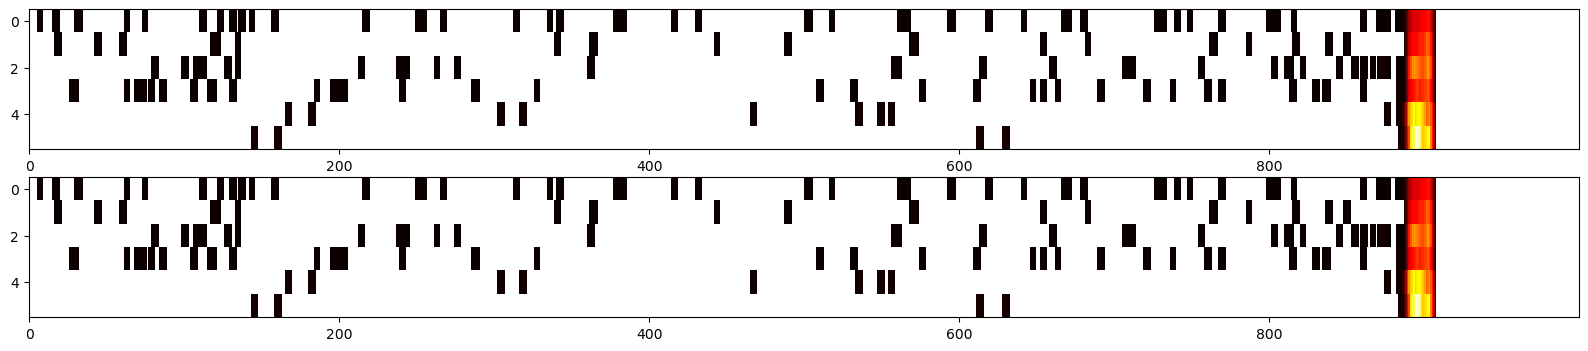

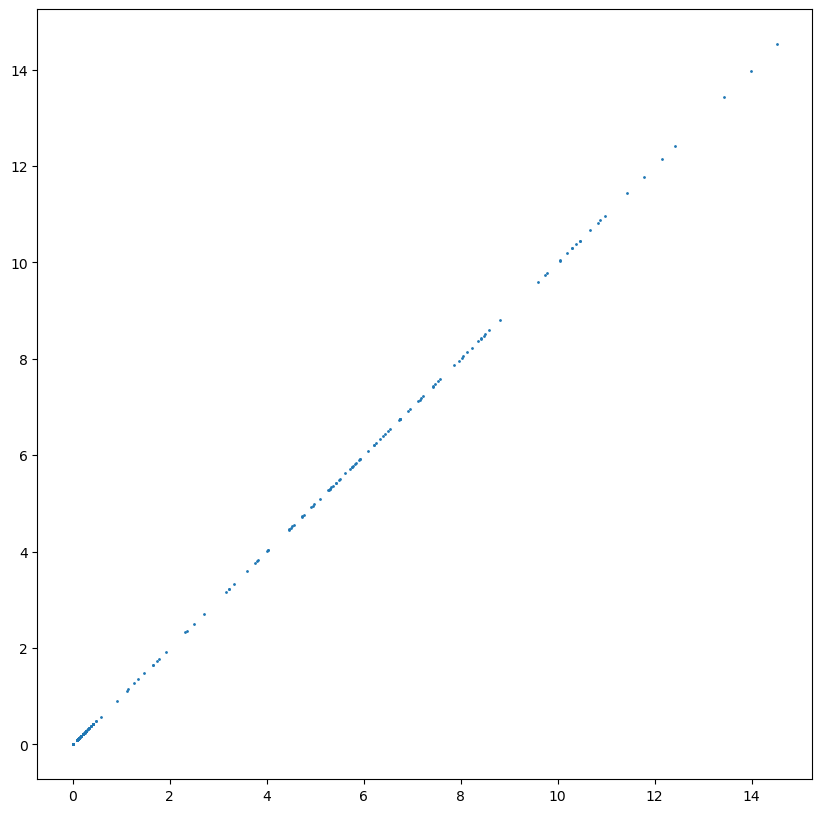

In [113]:
genome = 'mm10'
window_kb = 5
bin_size = 10

# load promoters
infile_promoter = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{window_kb}kb_filtered.bed" 
promoter = pd.read_csv(infile_promoter ,sep='\t')

tf = 'E2f1'

# experiment list 
infile=f"../resources/experimentList_{genome}_TFs_only_QC_filtered.tab"
experiment_tf = pd.read_csv(infile,sep='\t',usecols=[0,3])
experiment_tf.columns = ['id','antigen']
IDs = list(experiment_tf.loc[experiment_tf.antigen==tf,'id'])
bw_files = [f"../resources/tracks/{genome}/{id}.bw" for id in IDs]


# get tensor dimention and initialize
N_prom = promoter.shape[0]
win_size = promoter.at[0,'end'] - promoter.at[0,'start']
N_pos = int(win_size/bin_size)
N_exp = len(bw_files)

my_prom = promoter.loc[promoter.gene=='Tcstv3',:] 

start = time.time()
X = np.zeros([N_pos,N_exp])
for e,exp in enumerate(bw_files):
    bw = pyBigWig.open(exp)
    p = my_prom.index[0]
    [chr,start,end] = promoter.loc[p,['chr','start','end']]

    X[:,e] = np.array( bw.stats(chr, start, end, type="mean", nBins=N_pos) ).astype(float)
end = time.time()
print(end - start)

start = time.time()
X_ = np.zeros([N_pos,N_exp])
for e,exp in enumerate(bw_files):
    bw = pyBigWig.open(exp)
    p = my_prom.index[0]
    
    [chr,start,end] = promoter.loc[p,['chr','start','end']]

    vals = np.array(bw.intervals(chr,start,end))
    idx = (vals[:,:2] - start).astype(int)
    idx[idx<0] = 0
    idx[idx>=2*window_kb*1000] = 2*window_kb*1000-1
    vals = vals[:,2]

    Vals = np.zeros(2*window_kb*1000)*np.nan
    for i in range(len(vals)):
        Vals[idx[i,0]:idx[i,1]] = vals[i]
    
    X_[:,e] = np.nanmean( Vals.reshape(N_pos,bin_size), axis=1)
end = time.time()
print(end - start)


fig, axes = plt.subplots(2,1,figsize=(20,4))
ax = axes[0]
ax.imshow(X.T, aspect='auto', cmap='hot', interpolation='none')
ax = axes[1]
ax.imshow(X_.T, aspect='auto', cmap='hot', interpolation='none')

X[np.isnan(X)] = 0
X_[np.isnan(X_)] = 0

fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.scatter(X.flatten(),X_.flatten(),s=1)

